# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [2]:
# Libraries Import
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector

import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ColabNotebooks/')


Mounted at /content/drive


In [4]:
warnings.filterwarnings('ignore')

In [3]:
# Imprort the vehicles data file
data = pd.read_csv('data/vehicles.csv')
data_orig = data.copy()
data.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [5]:
# Understanda the data and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [6]:
#Install the profile and report
!pip install pandas-profiling
from ydata_profiling import ProfileReport
!pip install category_encoders

import category_encoders as ce

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=2e5e747c6a16fe8699fe09712a510491cba697aad39e618cd645ed918d7809ba
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00


In [9]:
#run the profile report
profile = ProfileReport(data)
profile.to_file(output_file='data/output.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

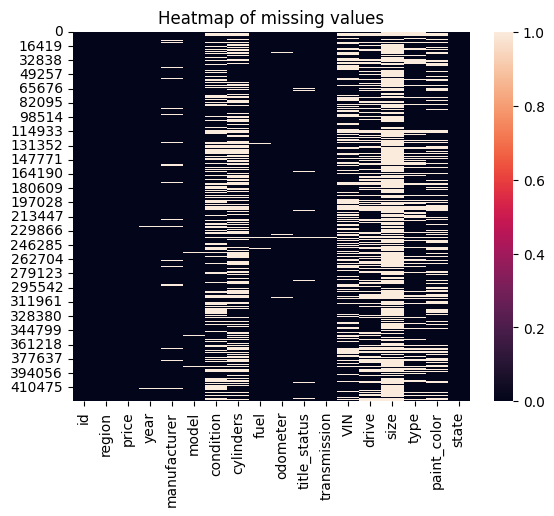

In [7]:
# Plot the heatmap of missing values
missing_values = sns.heatmap(data.isna())
missing_values.set_title("Heatmap of missing values")
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

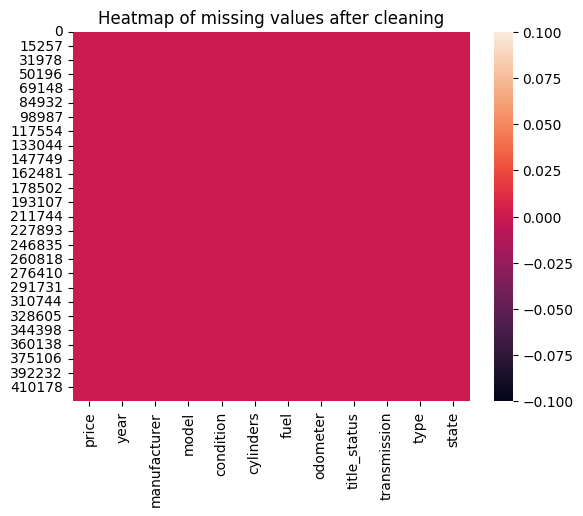

In [8]:

# Droping unique value columns as it can't be used for model. id, vin
# Droping region as state can be used instead
# Dropping size as 71% information is missing
# Dropping paint_color as 30% information is missing
# Dropping Drive as 30% information is missing

data_clean = ' '
# Removing records with price = 0
data_clean = data.query('price > 0')
data_clean = data_clean.drop(['id', 'VIN', 'region', 'size', 'paint_color', 'drive'], axis=1)


#Mejority of Manufacturer, type, fuel, transmission and Model is other. Fill with other
data_clean['manufacturer'] = data_clean['manufacturer'].fillna('other')
data_clean['model'] = data_clean['model'].fillna('other')
data_clean['fuel'] = data_clean['fuel'].fillna('other')
data_clean['transmission'] = data_clean['transmission'].fillna('other')
data_clean['type'] = data_clean['type'].fillna('other')


# Fill the condition, odometer, title status with appropriate value based on the data given
data_clean['condition'] = data_clean['condition'].fillna(data_clean['condition'].mode()[0])
data_clean['title_status'] = data_clean['title_status'].fillna(data_clean['title_status'].mode()[0])
data_clean['odometer'] = data_clean['odometer'].fillna(data_clean['odometer'].mean())

# Fill the Year with appropriate value based on the data given
data_clean['year'] = data_clean['year'].fillna(data_clean['year'].mode()[0])
data_clean['year'] = data_clean['year'].apply(lambda x: int(x))

# Clean the column, replace missing value with most occuring
data_clean["cylinders"] = data_clean['cylinders'].str.replace(' cylinders', '')
data_clean["cylinders"] = data_clean["cylinders"].fillna(data_clean["cylinders"].mode()[0])
data_clean["cylinders"] = data_clean['cylinders'].str.replace('other', data_clean["cylinders"].mode()[0])

# Removing duplicated records
data_clean = data_clean.drop_duplicates()


#
missing_values = sns.heatmap(data_clean.isna())
missing_values.set_title("Heatmap of missing values after cleaning")
plt.show()

In [17]:
data_clean = data_clean.sample(n=1000, random_state=42).copy()

 lower: -21135.0, upper: 53625.0
               price         year      odometer
count    1000.000000  1000.000000  1.000000e+03
mean    17836.595000  2009.888000  1.081210e+05
std     17959.459683    10.357738  2.553051e+05
min         1.000000  1929.000000  0.000000e+00
25%      6900.000000  2007.000000  4.033775e+04
50%     12999.000000  2012.000000  9.128200e+04
75%     25590.000000  2016.250000  1.399985e+05
max    349999.000000  2022.000000  7.603892e+06
              price         year      odometer
count    990.000000   990.000000  9.900000e+02
mean   17213.860606  2009.860606  1.085862e+05
std    13618.649680    10.380076  2.564684e+05
min      180.000000  1929.000000  0.000000e+00
25%     6912.500000  2007.000000  4.105325e+04
50%    12999.000000  2012.000000  9.135650e+04
75%    25000.000000  2016.000000  1.399995e+05
max    69900.000000  2022.000000  7.603892e+06


price  year manufacturer                       model  condition  \
2701    15997  2007        lexus                      ls 460       good   
218742   9500  1990       toyota                       supra       good   
348495  11995  2002       toyota                     4runner       good   
186695  23995  2013    chevrolet              silverado 1500  excellent   
96961    5800  2011        mazda              mazda6 i sport  excellent   
373890  52990  2020       jaguar    e-pace p300 r-dynamic se       good   
17272   18999  2016         jeep  renegade trailhawk 4x4 4dr       good   
285851  38257  2020          ram              promaster city        new   
82633    7000  2006          gmc                 sierra 1500  excellent   
357044  13289  2017        buick                      encore       good   

       cylinders fuel  odometer title_status transmission    type state  
2701           8  gas  126495.0        clean    automatic   sedan    al  
218742         6  gas  150000.0        clean    automatic   other    ms  
348495         6  gas  157438.0        clean    automatic     SUV    sc  
186695         6  gas   50798.0        clean    automatic  pickup    ma  
96961          4  gas  140220.0        clean    automatic   sedan    fl  
373890         6  gas      79.0        clean        other   other    tx  
17272          6  gas   91359.0        clean    automatic   other    ar  
285851         4  gas      20.0        clean    automatic   other    nh  
82633          8  gas  223000.0        clean    automatic  pickup    co  
357044         4  gas   91011.0        clean    automatic     SUV    tn

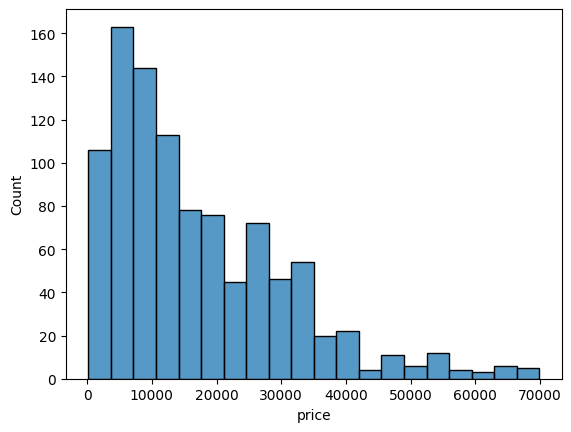

In [19]:
# Removing outliers from the data
first_quartile = data_clean['price'].quantile(.25)
third_quartile = data_clean['price'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - (1.5*iqr)
upper = third_quartile + (1.5*iqr)
print( f' lower: { lower }, upper: { upper }')

lower = 100
upper = 70000
data_clean_no_ol = data_clean.query( f'price > { lower } and price < { upper }' )

print(data_clean.describe())
print(data_clean_no_ol.describe())
sns.histplot(data_clean_no_ol['price'])

data_clean_no_ol.head(10)


In [20]:

# Regression Analysis
# Splitting the dataset into Train and Test

X = data_clean_no_ol.drop('price', axis = 1)
y = data_clean_no_ol['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)
features = X.columns
features

# Define Model_Results array
model_results = []



In [21]:
# Enconding columns to apply regression
target_encoder= ' '
df_target_encoded = ' '
target_encoder = ce.TargetEncoder()
df_target_encoded = target_encoder.fit_transform(data_clean_no_ol[features], data_clean_no_ol["price"])

X1 = df_target_encoded
y1 = data_clean_no_ol["price"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 23)

# Training the model with LinearRegression
first_degree_model = LinearRegression().fit(X1_train, y1_train)

# Executing predictions
pred_train = first_degree_model.predict(X1_train[features])
pred_test = first_degree_model.predict(X1_test[features])

# Obtaining errors for training and test datasets
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results array with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LinearRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2
})


# Do the above linear regression with One hot encoding
#OneHotEncoder = ' '
#df_OneHotEncoder = ' '
#features = X.columns
#OneHotEncoder = ce.OneHotEncoder()
#df_OneHotEncoder = OneHotEncoder.fit_transform(data_clean_no_ol[features], data_clean_no_ol["price"])

#X2 = df_OneHotEncoder
#y2 = data_clean_no_ol["price"]

#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 23)
#LinearRegression = LinearRegression().fit(X2_train, y2_train)

#pred_train = LinearRegression.predict(X2_train)
#pred_test = LinearRegression.predict(X2_test)

#train_mse = mean_squared_error(y_train, pred_train)
#test_mse = mean_squared_error(y_test, pred_test)

#print(f'Train MSE: {train_mse}')
#print(f'Test MSE: {test_mse}')

Train R2: 0.7887999685565841
Test R2: 0.7897906230626246
Train MSE: 40659888.7514334
Test MSE: 35388199.061715074


In [22]:
# Linear regression with Polynomial
# Using GridSearchCV, including Target encoder and polynomial features
cat_columns = data_clean_no_ol.select_dtypes(include='object').columns

column_transformer = make_column_transformer(
    (ce.TargetEncoder(), cat_columns),
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Defining a pipeline doing columns transformations, scaling data and performing LinearRegression
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Different degrees to use over the PolynomialFeatures function
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]
}
gscv_linreg = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
gscv_linreg.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_linreg.best_estimator_.predict(X_train[features])
pred_test = gscv_linreg.best_estimator_.predict(X_test[features])

# Evaluating the errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

#Print Grid search parameters
print(gscv_linreg.best_params_)
print(gscv_linreg.best_score_)

#update model_results array with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LinearRegression-Poly',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_linreg.best_score_
})


Train MSE: 36056818.19882477
Test MSE: 155962736.0708317
Train R2: 0.8127097399627572
Test R2: 0.07356603488855362
{'transformer__polynomialfeatures__degree': 1}
0.07378754028716165


In [33]:
#Ridge Regression
cat_columns = data_clean_no_ol.select_dtypes(include='object').columns

column_transformer = make_column_transformer(
    (ce.TargetEncoder(), cat_columns),
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Defining a pipeline doing columns transformations, scaling data and performing LinearRegression
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Different degrees to use over the PolynomialFeatures function
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(0, 5, 10)
}


gscv_ridge = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
ridge_pipefit=gscv_ridge.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_ridge.best_estimator_.predict(X_train[features])
pred_test = gscv_ridge.best_estimator_.predict(X_test[features])

# Evaluating the errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'RidgeRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_ridge.best_score_
})

# Using Premutation importance for selecting features
from sklearn.inspection import permutation_importance
r = permutation_importance(ridge_pipefit, X_test, y_test, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Train MSE: 60052733.309792325
Test MSE: 123439018.93466936
Train R2: 0.688067538973675
Test R2: 0.26676010794542593
year    0.073 +/- 0.012
model   0.060 +/- 0.024
fuel    0.052 +/- 0.007
state   0.025 +/- 0.007
transmission0.022 +/- 0.006
type    0.021 +/- 0.005
manufacturer0.020 +/- 0.008
cylinders0.014 +/- 0.004
condition0.012 +/- 0.006
odometer0.009 +/- 0.001
title_status0.008 +/- 0.003


In [34]:
#lasso regression
## Using transformations cover categorical columns

cat_columns = data_clean_no_ol.select_dtypes(include='object').columns


column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
    (ce.TargetEncoder(), cat_columns),
)

# Using a pipelne to perform a lasso regression over scaled and transformed data
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state = 23))
])

# Parameters used over the polynomial features
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]
}
gscv_lasso = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
features= X.columns
lasso_pipefit=gscv_lasso.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_lasso.best_estimator_.predict(X_train[features])
pred_test = gscv_lasso.best_estimator_.predict(X_test[features])

# Getting errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LassoRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_lasso.best_score_
})


# Using Premutation importance for selecting features
from sklearn.inspection import permutation_importance
r = permutation_importance(lasso_pipefit, X_test, y_test, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


Train R2: 0.8127096759527697
Test R2: 0.07356678986080833
Train MSE: 36056830.52192414
Test MSE: 155962608.9732263
model   0.174 +/- 0.056
year    0.084 +/- 0.014
fuel    0.024 +/- 0.003
state   0.022 +/- 0.007
condition0.009 +/- 0.004
cylinders0.009 +/- 0.003
odometer0.008 +/- 0.001
title_status0.008 +/- 0.003
manufacturer0.003 +/- 0.001


In [25]:
# Linear regression with Sequential feature selection
column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
    (ce.TargetEncoder(), cat_columns),
)

# Pipeline use to apply a Linear regression and SequentialFeatureSelector once data has being transformed
pipe = Pipeline([
    ('transformer', column_transformer),
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('model', LinearRegression())
])

# Params to iterate over the selector
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
gscv_sf = GridSearchCV(pipe, param_grid=param_dict)

# Training the model
gscv_sf.fit(X_train, y_train)

# Obtaining predictions
pred_train = gscv_sf.best_estimator_.predict(X_train[features])
pred_test = gscv_sf.best_estimator_.predict(X_test[features])

# Calculating errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'SeqFeatureSelRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_sf.best_score_
})


Train R2: 0.8251436145927702
Test R2: 0.1750698519987408
Train MSE: 33663068.74836106
Test MSE: 138874833.81949994


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [26]:
model_results

[{'model': 'LinearRegression',
  'train_mse': 40659888.7514334,
  'test_mse': 35388199.061715074,
  'train_r2': 0.7887999685565841,
  'test_r2': 0.7897906230626246},
 {'model': 'LinearRegression-Poly',
  'train_mse': 36056818.19882477,
  'test_mse': 155962736.0708317,
  'train_r2': 0.8127097399627572,
  'test_r2': 0.07356603488855362,
  'gridParams': 0.07378754028716165},
 {'model': 'RidgeRegression',
  'train_mse': 60052733.309792325,
  'test_mse': 123439018.93466936,
  'train_r2': 0.688067538973675,
  'test_r2': 0.26676010794542593,
  'gridParams': 0.21965076628834423},
 {'model': 'LassoRegression',
  'train_mse': 36056830.52192414,
  'test_mse': 155962608.9732263,
  'train_r2': 0.8127096759527697,
  'test_r2': 0.07356678986080833,
  'gridParams': 0.07378990460049535},
 {'model': 'SeqFeatureSelRegression',
  'train_mse': 33663068.74836106,
  'test_mse': 138874833.81949994,
  'train_r2': 0.8251436145927702,
  'test_r2': 0.1750698519987408,
  'gridParams': 0.1666912907191608}]

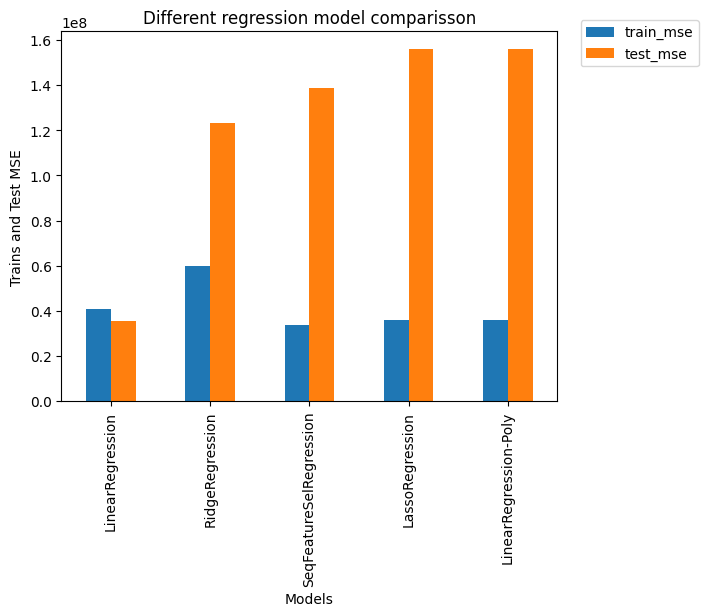

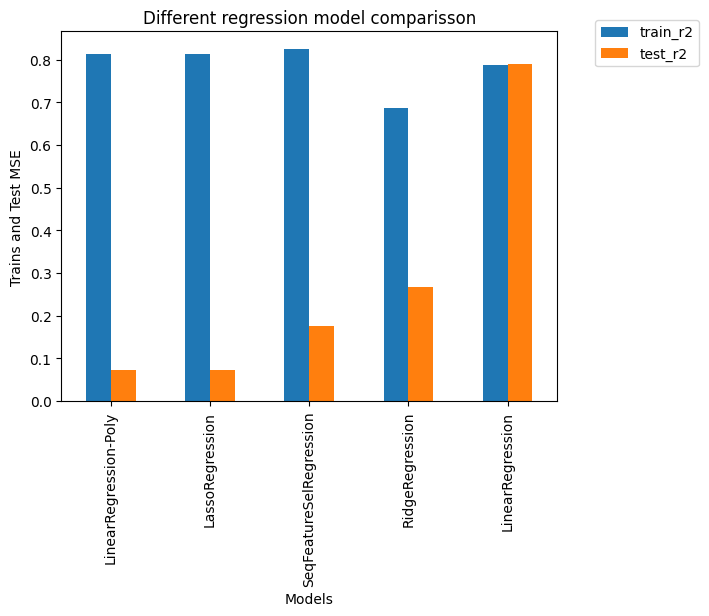

In [29]:
df_model_results = pd.DataFrame(model_results)
# Plotting the results obtained by executing different regression models. Comparing train mse and test mse
df_model_results[['model', 'train_mse', 'test_mse']].sort_values('test_mse', ascending=True).plot(x='model', kind='bar', stacked=False)

plt.xlabel("Models")
plt.ylabel("Trains and Test MSE")
plt.title('Different regression model comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))

df_model_results[['model', 'train_r2', 'test_r2']].sort_values('test_r2', ascending=True).plot(x='model', kind='bar', stacked=False)

plt.xlabel("Models")
plt.ylabel("Trains and Test MSE")
plt.title('Different regression model comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))

ValueError: could not convert string to float: 'lexus'

<Figure size 1600x600 with 0 Axes>

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.